# Baseline Model

I will use the test set to measure accuracy of these baseline models; however, note that hyperparameter tuning and model selection with more complex models will use validation sets or cross-validation to prevent adding bias to our final model.

In [1]:
# check how many of my cores/cpus are being used
import os
import multiprocessing

def cpu_count():
    return os.cpu_count()

def main():
    print(cpu_count())

main()

8


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')
import src.data_loader as dl

## Majority Class Classifier

Our minimal lower bound will be modeled by a majority class classifier. Because scratch is the most common class, we will always predict an image is a scratch.

In [16]:
true_labels = pd.read_csv('../data/processed/test/labels.csv')['label'].values
pred_labels = np.array([2]*len(true_labels))

f1_weighted = f1_score(true_labels, pred_labels, average='weighted')
print(f'F1: {f1_weighted:.3f}')
accuracy = accuracy_score(true_labels, pred_labels)
print(f'Accuracy: {accuracy:.3f}')

F1: 0.167
Accuracy: 0.334


## Logistic Regression

In [ ]:
X_train_flat = dl.load_data('../data/processed/train/images/', flat=True)
X_test_flat = dl.load_data('../data/processed/test/images/', flat=True)
y_train = pd.read_csv('../data/processed/train/labels.csv')['label'].values
y_test = pd.read_csv('../data/processed/test/labels.csv')['label'].values
print(X_train_flat.shape)
print(X_test_flat.shape)
print(y_train.shape)
print(y_test.shape)

(5623, 23400)
(1406, 23400)
(5623,)
(1406,)


In [12]:
clf = LogisticRegression(max_iter=100, n_jobs=-1, C=0.1)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f'Weighted F1: {f1_weighted:.3f}')
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# OUTPUT
# Weighted F1: 0.251
# Accuracy: 0.251

Weighted F1: 0.263
Accuracy: 0.278


/Users/landon/anaconda3/envs/proj492/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


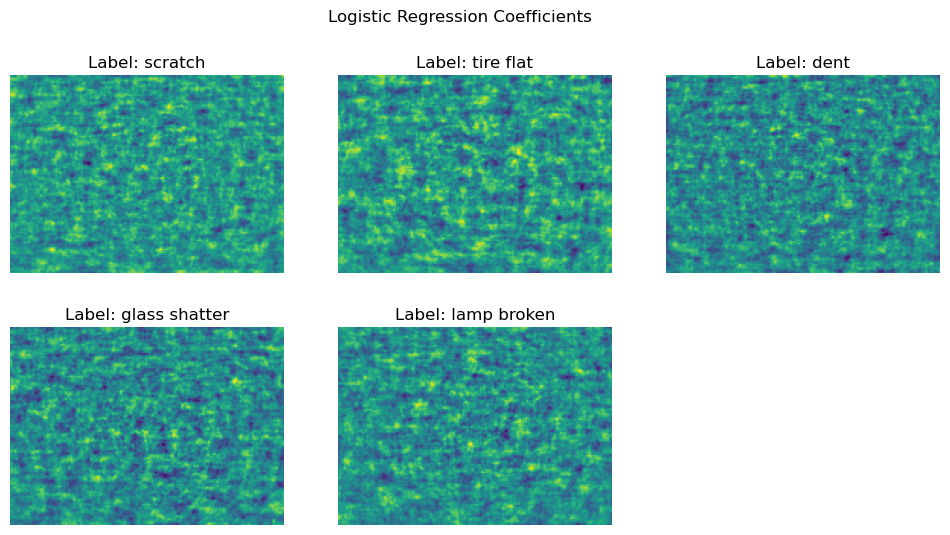

In [22]:
label_code = pd.Series({1: 'crack', 2: 'scratch', 3: 'tire flat', 4: 'dent', 5: 'glass shatter', 6: 'lamp broken'})

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.imshow(clf.coef_[i].reshape(130, 180))
    plt.axis('off')
    plt.title(f'Label: {label_code[clf.classes_[i]]}')
plt.suptitle('Logistic Regression Coefficients')
plt.show()

## MLP

In [13]:
# use flat data to train sklearn mlp
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(250, 50), max_iter=1000)
mlp.fit(X_train_flat, y_train)

MLPClassifier(hidden_layer_sizes=(250, 50), max_iter=1000)

In [14]:
y_pred = mlp.predict(X_test_flat)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f'Weighted F1: {f1_weighted:.3f}')
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Weighted F1: 0.231
Accuracy: 0.318


## Shallow Quick Train CNN

In [ ]:
X_train = dl.load_data('../data/processed/train/images/')
X_test = dl.load_data('../data/processed/test/images/')
y_train = pd.read_csv('../data/processed/train/labels.csv')['label'].values
y_test = pd.read_csv('../data/processed/test/labels.csv')['label'].values
y_train_sparse = np.zeros((y_train.size, 5))
for i, y in enumerate(y_train):
    y_train_sparse[i, y-2] = 1
y_train = y_train_sparse
y_test_sparse = np.zeros((y_test.size, 5))
for i, y in enumerate(y_test):
    y_test_sparse[i, y-2] = 1
y_test = y_test_sparse
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [42]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(130, 180, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5


/Users/landon/anaconda3/envs/proj492/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - accuracy: 0.2852 - loss: 70.4155 - val_accuracy: 0.3357 - val_loss: 1.5109
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.3639 - loss: 1.4730 - val_accuracy: 0.3300 - val_loss: 1.5049
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.4145 - loss: 1.3731 - val_accuracy: 0.3144 - val_loss: 1.5903
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 174ms/step - accuracy: 0.4707 - loss: 1.2402 - val_accuracy: 0.3172 - val_loss: 1.6491
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.5439 - loss: 1.1092 - val_accuracy: 0.2973 - val_loss: 1.8859


In [43]:
# test weighted f1 and accuracy of model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) + 2
y_test = np.argmax(y_test, axis=1) + 2
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f'Weighted F1: {f1_weighted:.3f}')
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
Weighted F1: 0.261
Accuracy: 0.297
